### Imports

In [7]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from gwpy.timeseries import TimeSeries
from pycbc.detector import Detector
import bilby
from pesummary.io import read
from math import pi


# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [8]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak
    
def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

### Grab waveform from frames files

In [9]:
def GetFramesData(p, det = 'H1'):
    
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    return tH, sH

### Grab injected parameters (for surrogate)

In [4]:
def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Get Bilby parameters

In [28]:
def GetBilbyParameters(p):

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(result.posterior['log_likelihood'])
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    maxP_point = result.posterior.iloc[maxP_ind]
    
    return maxP_point

def GetBilbyDict(BilbyRes):
    
    BilbyDict = {} ##maxL_point
    print(BilbyRes)
    BilbyDict['q'] = 1.0/BilbyRes['mass_ratio']
    BilbyDict['dt'] = 1.0/2048.
    q = BilbyDict['q']
    BilbyDict['mass'] = BilbyRes['chirp_mass'] * (q/(1+q)**2)**(-3/5)
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['theta'] = BilbyRes['theta_jn']
    BilbyDict['phi'] = BilbyRes['phase'] ## Is this right?
    a_1 = BilbyRes['a_1']
    a_2 = BilbyRes['a_2']
    BilbyDict['a_1'] = [0, 0, a_1] ## Assume spin-aligned for now
    BilbyDict['a_2'] = [0, 0, -a_2] ## Assume spin anti-aligned for now
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['t_gps'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## Is this right?
    return BilbyDict
    
    

### Get Surrogate waveforms

#### Import surrogate

In [6]:
import gwsurrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


#### Evaluate Surrogate

In [11]:
## Surrogate evaluation
def EvaluateSurrogate(params_dict):
    """ Evaluate the surrogate waveform """
   
    """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
             hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
             the sky of the reference frame is returned.

        In order to agree with NR convetions, need phi_ref = pi/2 - phi"""

    data = sur(params_dict['q'], params_dict['a_1'], params_dict['a_2'], \
               dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
               dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
               inclination = params_dict['theta'], ellMax = 4, phi_ref = pi/2 - params_dict['phi']) 

    time = data[0]
    h_plus = np.real(data[1])
    h_cross = -1 * np.imag(data[1])

    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)




### Get BW reconstructed waveforms


In [12]:
def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetMedianData(p, det = 'H1'):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ## Grab Livingston data
    f = GetBWDir(p) + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1 #, d2, d3, d4, d5

def GetInjectedData(p, det = 'H1'):

    f = GetBWDir(p) + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data

### Plot reconstructions

In [25]:
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/dCS_0p0_125'

BW_inj_time, BW_inj_strain = GetInjectedData(p)
BW_rec_time, BW_rec_strain = GetMedianData(p)
t_frame, data_frame = GetFramesData(p)

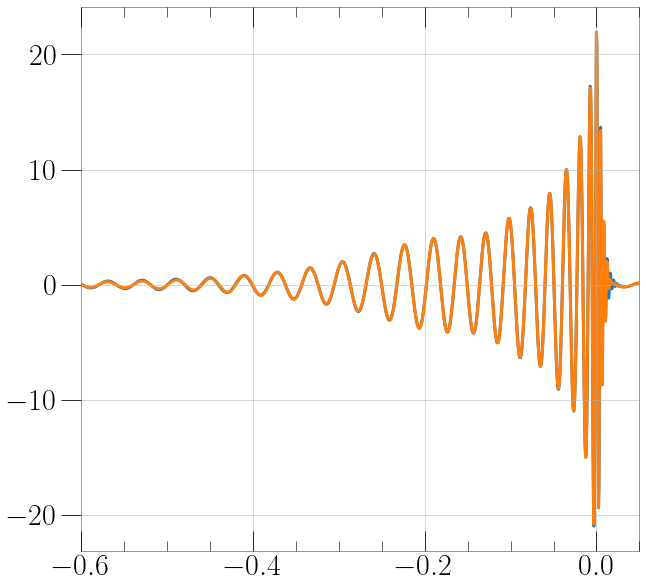

In [24]:
plt.figure(figsize=(10,10))
plt.plot(BW_inj_time, BW_inj_strain)
plt.plot(BW_rec_time, BW_rec_strain)
#plt.plot(t_frame, data_frame, '--')
plt.xlim(-0.6, 0.05)
plt.show()

In [29]:
BilbyParameters = GetBilbyParameters('/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/dCS_0p0_125')
bilby_dict = GetBilbyDict(BilbyParameters)
My_Params_Dict = bilby_dict #truth_dict
time, h_plus, h_cross, amp = EvaluateSurrogate(My_Params_Dict)
timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, My_Params_Dict)

#params_dict = GetBilbyParameters(p)
#truth_dict = GetInjectedParameters(p)

mass_ratio             9.652020e-01
chirp_mass             2.964289e+01
a_1                    5.358215e-01
a_2                    5.486778e-01
luminosity_distance    2.474476e+02
psi                    2.781709e+00
phase                  1.743555e+00
geocent_time           1.126259e+09
tilt_1                 0.000000e+00
tilt_2                 3.141593e+00
phi_12                 0.000000e+00
phi_jl                 0.000000e+00
dec                   -1.269672e+00
ra                     1.952319e+00
theta_jn               3.141593e+00
log_likelihood         1.073743e+04
log_prior             -1.704539e+01
Name: 36660, dtype: float64


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(BW_inj_time, BW_inj_strain)
plt.plot(BW_rec_time, BW_rec_strain)
#plt.plot(t_frame, data_frame, '--')
plt.xlim(-0.6, 0.05)
plt.show()